In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def parse_line_data(line):
    i = 0
    coor_point_x = 0
    coor_point_y = 0
    size_label_x = 0
    size_label_y = 0
    labels = []
    for element in line.split():
        point = element.find(",")
        len_el = len(element)
        if i == 0:
            coor_point_x = int(element[:point])
            coor_point_y = int(element[point + 1:len_el])
        if i == 1:
            size_label_x = int(element[:point])
            size_label_y = int(element[point + 1:len_el])
        if i > 1:
            coor_label_x = int(element[:point])
            coor_label_y = int(element[point + 1:len_el])
            labels.append([coor_label_x, coor_label_y])
        i += 1
    return [coor_point_x, coor_point_y], [size_label_x, size_label_y], labels

In [3]:
def read_data(file_path):
    coor_points = []
    size_labels = []
    coor_labels = []
    file = open(file_path, "r").read() 
    for line in file.split("\n"):
        coor_point, size_label, coor_label = parse_line_data(line)
        coor_points.append(coor_point)
        size_labels.append(size_label)
        coor_labels.append(coor_label)
    return coor_points, size_labels, coor_labels

In [4]:
def set_nodes_graph(G, coor_points, coor_labels, size_labels):
    for i in range(len(coor_points)):
        G.add_node("+" + str(i), coordinates=(coor_points[i][0], coor_points[i][1]))
        G.add_node("-" + str(i), coordinates=(coor_points[i][0], coor_points[i][1]))
    return G

In [5]:
def is_overlap(x_1, y_1, x_2, y_2, s_1, s_2):
    l1 = (x_1 <= x_2 and x_2 <= x_1 + s_1[0]
            or
            x_2 <= x_1 and x_1 <= x_2 + s_2[0])
    l2 = (y_1 <= x_2 and x_2 <= y_1 + s_1[1]
            or
            x_2 <= y_1 and y_1 <= x_2 + s_2[1])
    return l1 and l2

In [6]:
def get_prefix(z, k):
    if z == 0 and k == 0:
        return "-", "+", "-", "+"
    if z == 0 and k == 1:
        return "-", "-", "+", "+"
    if z == 1 and k == 0:
        return "+", "+", "-", "-"
    if z == 1 and k == 1:
        return "+", "-", "+", "-"

In [7]:
def add_overlap(G, coor_points, coor_labels, size_labels, i, j, z, k):
    x_1 = coor_points[i][0] - coor_labels[i][z][0]
    y_1 = coor_points[i][1] - coor_labels[i][z][1]
    x_2 = coor_points[j][0] - coor_labels[j][k][0]
    y_2 = coor_points[j][1] - coor_labels[j][k][1]
    
    if is_overlap(x_1, y_1, x_2, y_2, size_labels[i], size_labels[j]):
        ch1_1, ch1_2, ch2_1, ch2_2 = get_prefix(z, k)
        G.add_edge(ch1_1 + str(i), ch1_2 + str(j))
        G.add_edge(ch2_1 + str(j), ch2_2 + str(i))
    return G

In [8]:
def add_edge_graph(G, coor_points, coor_labels, size_labels, i, j):
    for z in range(0, 1):
        for k in range(0, 1):
            G = add_overlap(G, coor_points, coor_labels, size_labels, i, j, z, k)
    return G

In [9]:
def set_edges_graph(G, coor_points, coor_labels, size_labels):
    for i in range(len(coor_points)):
        for j in range(len(coor_points)):
            if i == j:
                continue
            G = add_edge_graph(G, coor_points, coor_labels, size_labels, i, j)
    return G

In [10]:
def get_order_node(G, order, visit_nodes, node):
    if visit_nodes[node]:
        return order, visit_nodes
    visit_nodes[node] = True
    for edge in G.out_edges(node):
        order, visit_nodes = get_order_node(G, order, visit_nodes, node)
    order.append(node)
    return order, visit_nodes

In [11]:
def get_order(G):
    visit_nodes = {}
    for node in G.nodes():
        visit_nodes[node] = False
    order = []
    for node in G.nodes():
        order, visit_nodes = get_order_node(G, order, visit_nodes, node)
    return order

In [12]:
def add_node_component(G, components, node, num_component):
    if components[node] != -1:
        return components
    components[node] = num_component
    for edge in G.in_edges(node):
        components = add_node_component(G, components, edge[0], num_component)
    return components

In [13]:
def get_components(G, order):
    components = {}
    num_component = 0
    for node in G.nodes():
        components[node] = -1
    for i in range(len(G.nodes())):
        node = order[len(G.nodes()) - i - 1]
        if components[node] == -1:
            num_component += 1
        components = add_node_component(G, components, node, num_component)
    return components

In [14]:
def get_comp_nodes(G, i):
    node1 = ""
    node2 = ""
    k = 0
    for node in G.nodes():
        if k == 2 * i:
            node1 = node
        if k == 2 * i + 1:
            node2 = node
        k += 1
    return node1, node2

In [15]:
def check_path(G, components):
    direction = [False] * (len(G.nodes()) // 2)
    for i in range(len(G) // 2):
        node1, node2 = get_comp_nodes(G,  i)
        if components[node1] == components[node2]:
            return False, direction
        direction[i] = components[node1] > components[node2]
    return True, direction

In [16]:
def can_be_draw(G):
    order = get_order(G)
    components = get_components(G, order)
    return check_path(G, components)

In [17]:
def settings_graph():
    x_lim = [-200, 200]
    y_lim = [-200, 200]
    fig_x = 15
    fig_y = 15
    node_size = 80
    font_size = 15
    with_labels = False
    return x_lim, y_lim, fig_x, fig_y, node_size, font_size, with_labels

In [18]:
def set_new_graph(coordinatesG, coor_points):
    new_G = nx.DiGraph(directed=True)
    for i in range(len(coor_points)):
        new_G.add_node("+" + str(i), coordinates = (coor_points[i][0], coor_points[i][1])) 
    return new_G

In [19]:
def full_ax(ax, direction, coor_points, coor_labels):
    x = 0
    y = 0
    for i in range(len(coor_points)):
        if (direction[i]):
            x = coor_points[i][0] - coor_labels[i][1][0]
            y = coor_points[i][1] - coor_labels[i][1][1]
        else:
            x = coor_points[i][0] - coor_labels[i][0][0]
            y = coor_points[i][1] - coor_labels[i][0][1]
        ax.add_patch(Rectangle((x, y),
                               coor_labels[i][0], coor_labels[i][1],
                               edgecolor='r', facecolor='none'))
    return ax

In [20]:
def draw_graph(coordinatesG, coor_points, direction, coor_labels):
    new_G = set_new_graph(coordinatesG, coor_points)
    x_lim, y_lim, fig_x, fig_y, node_size, font_size, with_labels = settings_graph()
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    nx.draw(new_G, coordinatesG, node_size=node_size, with_labels=with_labels)
    ax = full_ax(ax, direction, coor_points, coor_labels)
    plt.xlim(x_lim)
    plt.ylim(y_lim)

In [21]:
def read_graph(file_path):
    G = nx.DiGraph(directed=True)
    coor_points, size_labels, coor_labels = read_data(file_path)
    G = set_nodes_graph(G, coor_points, coor_labels, size_labels)
    G = set_edges_graph(G, coor_points, coor_labels, size_labels)
    valid, direction = can_be_draw(G)
    if valid:
        draw_graph(nx.get_node_attributes(G, 'coordinates'), coor_points, direction, coor_labels)
    else:
        print("Not valid view")

TypeError: unsupported operand type(s) for +: 'int' and 'list'

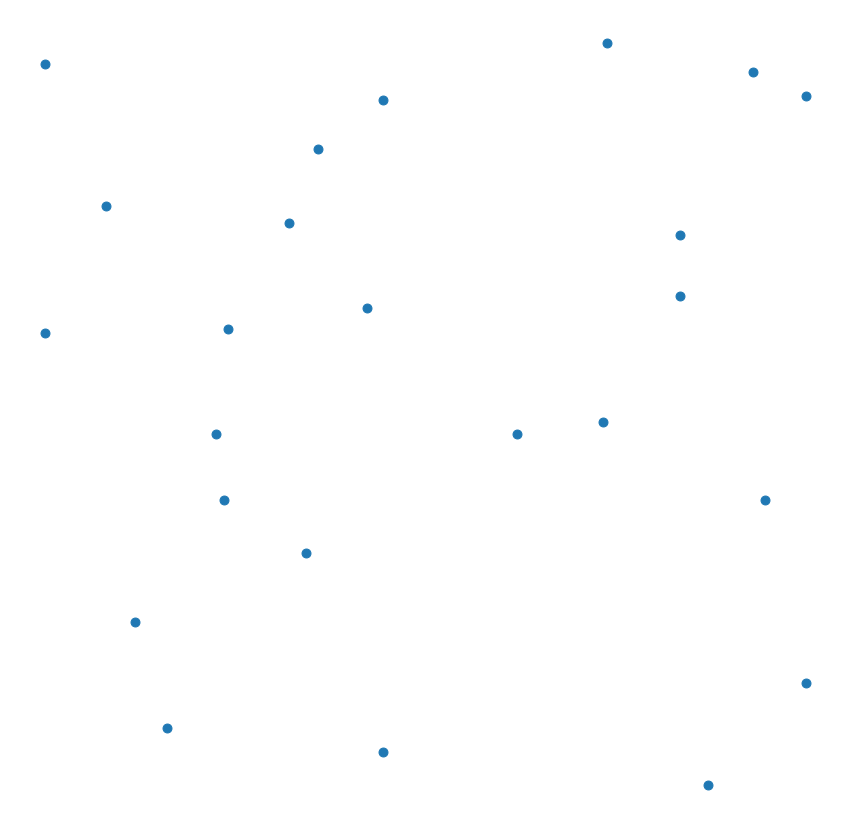

In [22]:
read_graph("test/bin1.txt")

In [ ]:
read_graph("test/bin4.txt")